#**Code**

In [ ]:
pip install nibabel matplotlib numpy scikit-image scikit-learn SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 15.8 MB/s eta 0:00:00


In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_nifti(path):
    """
    Load a NIfTI file and return:
      - data as a NumPy array
      - affine matrix
      - header
    """
    nii = nib.load(path)
    data = nii.get_fdata()   # float64 array
    affine = nii.affine
    header = nii.header
    return data, affine, header

In [ ]:
img_path  = "/content/drive/MyDrive/medical_images/Abdomen_CT directory/Case_00002_0000.nii"
mask_path = "/content/drive/MyDrive/medical_images/Abdomen_CT directory/Case_00002.nii"

img_vol, img_affine, img_header   = load_nifti(img_path)
mask_vol, mask_affine, mask_header = load_nifti(mask_path)

print("Image shape:", img_vol.shape)
print("Mask  shape:", mask_vol.shape)

Image shape: (512, 512, 64)
Mask  shape: (512, 512, 64)


In [ ]:
slice_idx = img_vol.shape[2] // 2  # middle slice

img_slice  = img_vol[:, :, slice_idx]
mask_slice = mask_vol[:, :, slice_idx]

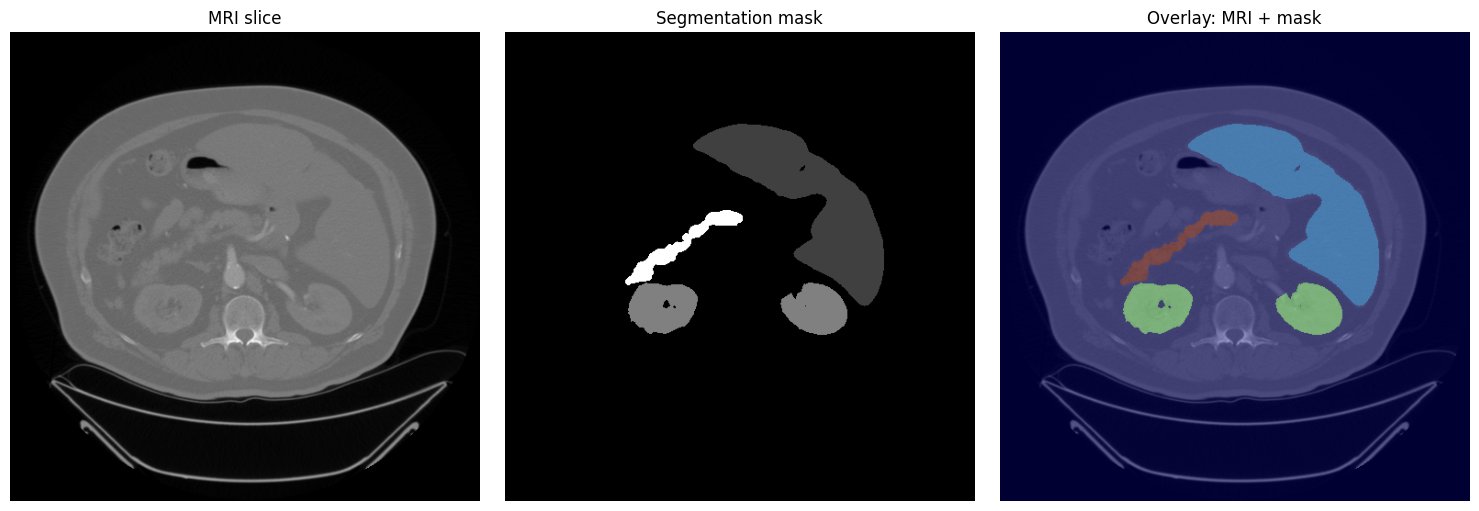

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img_slice.T, cmap='gray', origin='lower')
axs[0].set_title('MRI slice')
axs[0].axis('off')

axs[1].imshow(mask_slice.T, cmap='gray', origin='lower')
axs[1].set_title('Segmentation mask')
axs[1].axis('off')

axs[2].imshow(img_slice.T, cmap='gray', origin='lower')
axs[2].imshow(mask_slice.T, cmap='jet', alpha=0.4, origin='lower')
axs[2].set_title('Overlay: MRI + mask')
axs[2].axis('off')

plt.tight_layout()
plt.show()

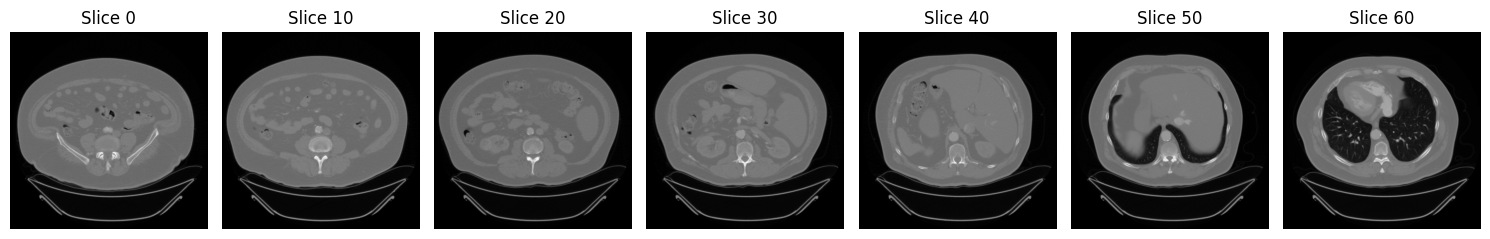

In [ ]:
def show_volume_slices(volume, step=10, cmap='gray'):
    """
    Show slices along the axial direction every `step` slices.
    """
    num_slices = volume.shape[2]
    fig, axs = plt.subplots(1, (num_slices // step) + 1, figsize=(15, 5))
    axs = np.atleast_1d(axs)

    for i, idx in enumerate(range(0, num_slices, step)):
        if i >= len(axs):
            break
        axs[i].imshow(volume[:, :, idx].T, cmap=cmap, origin='lower')
        axs[i].set_title(f"Slice {idx}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

show_volume_slices(img_vol, step=img_vol.shape[2] // 6)

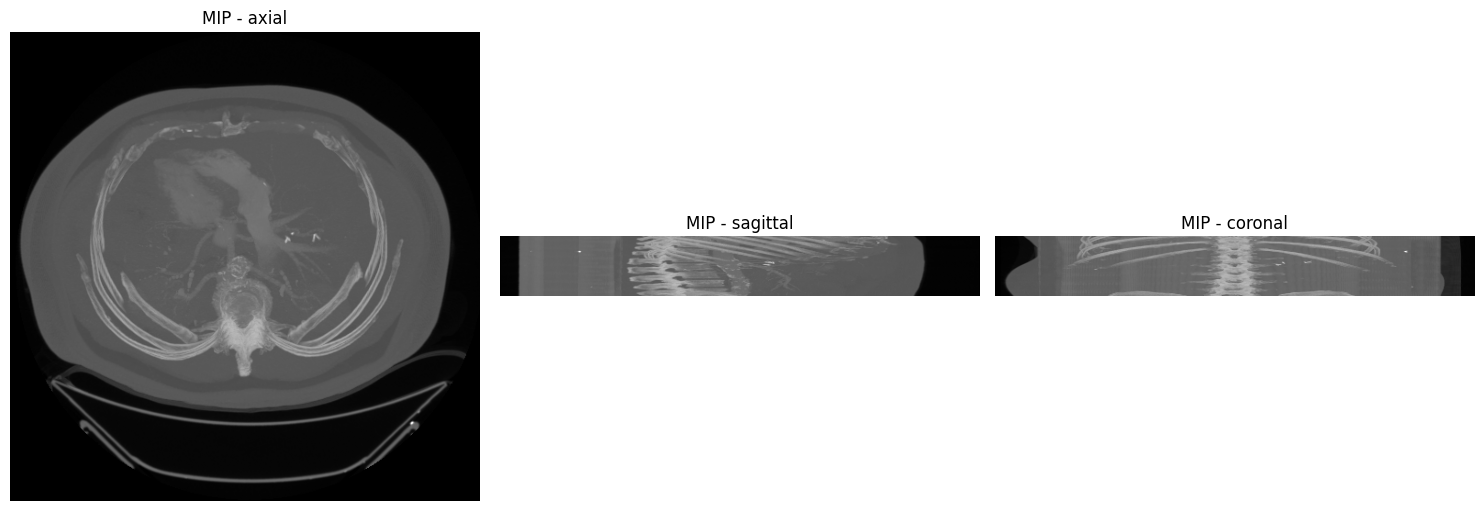

In [ ]:
mip_axial  = np.max(img_vol, axis=2)   # projection along z
mip_sag    = np.max(img_vol, axis=0)
mip_cor    = np.max(img_vol, axis=1)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(mip_axial.T, cmap='gray', origin='lower')
axs[0].set_title('MIP - axial')
axs[0].axis('off')

axs[1].imshow(mip_sag.T, cmap='gray', origin='lower')
axs[1].set_title('MIP - sagittal')
axs[1].axis('off')

axs[2].imshow(mip_cor.T, cmap='gray', origin='lower')
axs[2].set_title('MIP - coronal')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def compute_stats(values):
    values = values.astype(np.float64)
    return {
        "mean": float(np.mean(values)),
        "median": float(np.median(values)),
        "std": float(np.std(values)),
        "min": float(np.min(values)),
        "max": float(np.max(values)),
    }

In [ ]:
# Removing NaNs
img_flat = img_vol[~np.isnan(img_vol)]

# Masked voxels (only where mask > 0)
mask_bool = mask_vol > 0
segmented_voxels = img_vol[mask_bool]

whole_stats = compute_stats(img_flat)
seg_stats   = compute_stats(segmented_voxels)

print("Whole image stats:")
for k, v in whole_stats.items():
    print(f"  {k}: {v:.3f}")

print("\nSegmented region stats:")
for k, v in seg_stats.items():
    print(f"  {k}: {v:.3f}")

Whole image stats:
  mean: -549.307
  median: -874.000
  std: 478.643
  min: -1024.000
  max: 2125.000

Segmented region stats:
  mean: 37.406
  median: 35.000
  std: 26.267
  min: -136.000
  max: 961.000


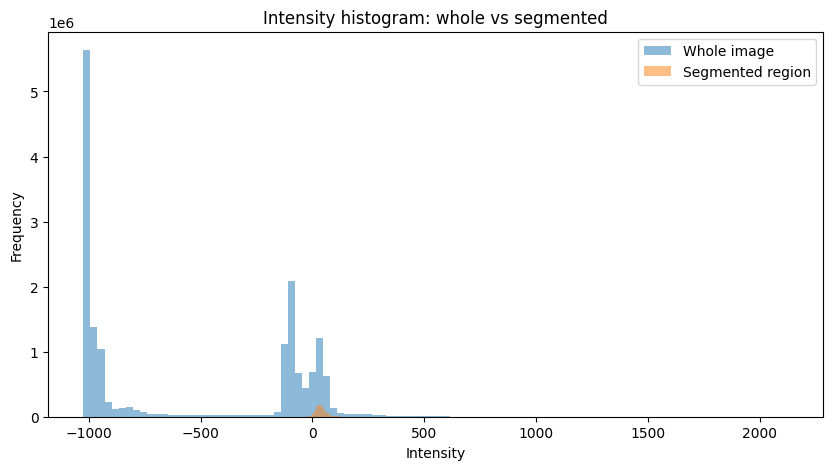

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(img_flat, bins=100, alpha=0.5, label='Whole image')
plt.hist(segmented_voxels, bins=100, alpha=0.5, label='Segmented region')
plt.legend()
plt.title('Intensity histogram: whole vs segmented')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
whole_stats = compute_stats(img_flat)
seg_stats   = compute_stats(segmented_voxels)

print("\n=== Statistical comparison ===")
for key in whole_stats.keys():
    print(f"{key.capitalize():>7}: whole = {whole_stats[key]:8.3f} | segmented = {seg_stats[key]:8.3f}")


=== Statistical comparison ===
   Mean: whole = -549.307 | segmented =   37.406
 Median: whole = -874.000 | segmented =   35.000
    Std: whole =  478.643 | segmented =   26.267
    Min: whole = -1024.000 | segmented = -136.000
    Max: whole = 2125.000 | segmented =  961.000


In [ ]:
total_voxels      = img_flat.size
segmented_count   = segmented_voxels.size
coverage_percent  = segmented_count / total_voxels * 100.0

print("\n=== Segmentation checks ===")
print(f"Total voxels in image     : {total_voxels}")
print(f"Voxels inside mask        : {segmented_count}")
print(f"Mask coverage of the image: {coverage_percent:.2f}%")

if segmented_count == 0:
    print("⚠️  Warning: segmentation mask is empty (no voxels > 0).")
elif coverage_percent < 0.1:
    print("⚠️  Warning: mask is extremely small; check if mask is correctly aligned.")
elif coverage_percent > 80:
    print("⚠️  Warning: mask covers most of the image; this is unusual for a local organ segmentation.")
else:
    print("✅ Mask size looks reasonable for an organ segmentation (not too small or too large).")

# 3) Intensity-based reasonableness check

diff_mean = seg_stats["mean"] - whole_stats["mean"]
print(f"\nDifference in mean intensity (segmented - whole): {diff_mean:.3f}")

if abs(diff_mean) < 0.01 * max(1.0, abs(whole_stats["mean"])):
    print("ℹ️  Segmented region has a mean intensity very similar to the whole image "
          "(could be fine if organ is not very distinct in intensity).")
elif diff_mean > 0:
    print("ℹ️  Segmented region is on average BRIGHTER than the overall image "
          "(common for some organs/tissues in MRI/CT).")
else:
    print("ℹ️  Segmented region is on average DARKER than the overall image "
          "(also  depends on the tissue and modality).")


=== Segmentation checks ===
Total voxels in image     : 16777216
Voxels inside mask        : 851506
Mask coverage of the image: 5.08%
✅ Mask size looks reasonable for an organ segmentation (not too small or too large).

Difference in mean intensity (segmented - whole): 586.712
ℹ️  Segmented region is on average BRIGHTER than the overall image (common for some organs/tissues in MRI/CT).


In [2]:
!jupyter nbconvert --to markdown Imaging_Trial.ipynb

[NbConvertApp] WARNING | pattern 'Imaging_Trial.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
 